### plotting ROIs

In [12]:
import os
import numpy as np

In [111]:
from nilearn.plotting import plot_stat_map, plot_roi
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.image import get_data, load_img, new_img_like, index_img

In [14]:
# load data and get display threshold
img = '../../../TSL_output/2ndLevel_io_jf_prob_mean_FDR0001/2ndLevel/con_0002/spmT_0001_thr.nii'
clean_map, threshold = threshold_stats_img(
    img, alpha=.001, height_control='fpr', cluster_threshold=10)

In [17]:
# get peak coordinates for plotting
table = get_clusters_table(clean_map, stat_threshold=threshold,
                           cluster_threshold=10)
# print(table)
table[['X','Y','Z']] = table[['X','Y','Z']].astype(int)
table[['Peak Stat']] = table[['Peak Stat']].round(3)
peaks = table[table['Cluster Size (mm3)'].astype(str).apply(lambda x: len(x))>0]

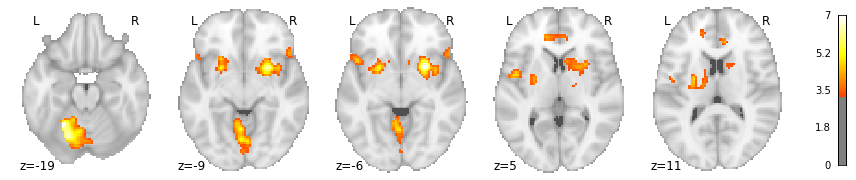

In [19]:
# plot cluster peaks
peak_z = np.unique(peaks['Z'])
g = plot_stat_map(clean_map, threshold=threshold, vmax=7,
              display_mode='z', cut_coords=(peak_z)) 

In [29]:
load_img(img)

In [47]:
# building masks from clusters 
img_data = get_data(img)#.astype(bool)
thresholded_img = new_img_like(img, img_data>3.3)

In [61]:
all_cluster_mask = get_data(load_img(thresholded_img)).astype(np.int)

In [62]:
sum(sum(sum(all_cluster_mask==1)))

1558

In [65]:
mask_img = new_img_like(img, all_cluster_mask)

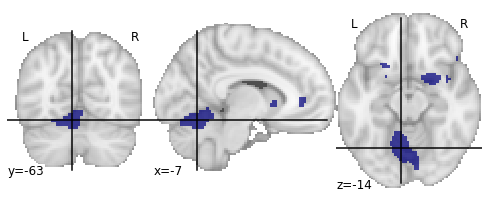

In [67]:
plot_roi(mask_img)

In [68]:
from scipy import ndimage

In [69]:
dil_all_cluster_mask = ndimage.binary_dilation(all_cluster_mask)

In [70]:
dil_all_cluster_mask_img = new_img_like(img, dil_all_cluster_mask.astype(np.int))

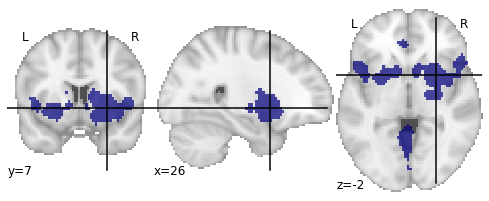

In [71]:
plot_roi(dil_all_cluster_mask_img)

In [193]:
labels, n_labels = ndimage.label(dil_all_cluster_mask)
# labels, n_labels = ndimage.label(all_cluster_mask)

In [195]:
labels.shape

(81, 96, 63)

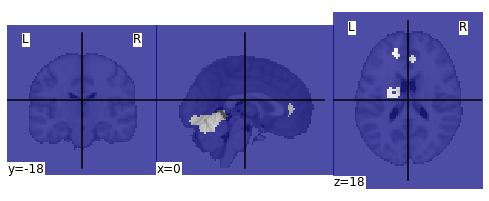

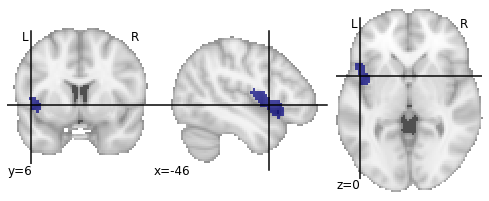

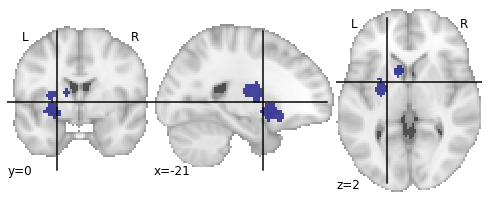

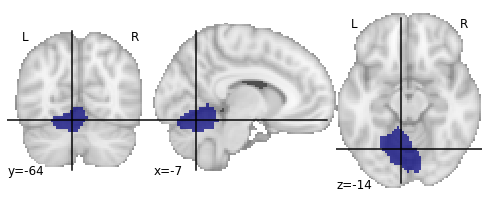

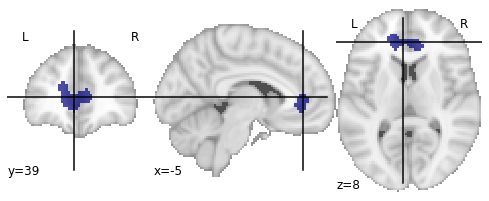

In [91]:
for n in range(n_labels):
    d = (labels==n).astype(int)
    d_img = new_img_like(img, d)
    plot_roi(d_img)

In [122]:
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
# dataset = datasets.fetch_atlas_harvard_oxford('sub-prob-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

In [130]:
from nilearn.regions import connected_label_regions
region_labels = connected_label_regions(atlas_filename)

In [147]:
region_labels_data = get_data(atlas_filename)

In [139]:
lb_ls = ['Left Putamen','Left Accumbens','Left Caudate','Right Caudate',
 'Right Putamen','Right Accumbens']

In [143]:
c = []
for i, x in enumerate(labels):
    for lb in lb_ls:
        if lb==x:
            c.append(i)

In [144]:
c

[5, 6, 11, 16, 17, 21]

In [158]:
# split and save individual rois
for idx in c:
    d = (region_labels_data==idx).astype(int)
    d_img = new_img_like(atlas_filename, d)
#     plot_roi(d_img)
    d_img.to_filename('./rois/'+labels[idx].replace(' ', '_')+'.nii')

In [155]:
# # check
# for f in os.listdir('./rois'):
#     plot_roi('./rois/' + f)

In [159]:
# extract ts
func_file = '../../../TSL_output/1stLevel_io_jf_prob_mean/1stLevel/sub-06/con_0002.nii'

In [160]:
mask_img = './rois/Left_Accumbens.nii'

In [208]:
from nilearn.image import resample_to_img
stat_img = mask_img
template = func_file
resampled_stat_img = resample_to_img(stat_img, template)
resampled_mask_data = get_data(resampled_stat_img).astype(np.int)
resampled_mask_img = new_img_like(template, resampled_mask_data)

/home/fs0/syzhang/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [211]:
load_img(func_file).shape

(81, 96, 63)

In [209]:
resampled_mask_img.shape

(81, 96, 63)

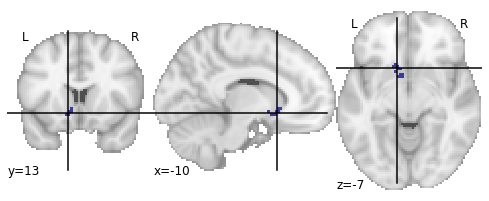

In [172]:
plot_roi(resampled_mask_img)

In [239]:
from nilearn.masking import apply_mask
func_file = '../../../TSL_output/smooth_nomask/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii'
masked_data = apply_mask(func_file, resampled_mask_img)

In [240]:
masked_data.shape

(242, 26)

In [241]:
import matplotlib.pyplot as plt

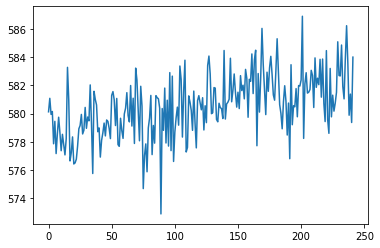

In [242]:
plt.plot(np.mean(masked_data,1))

In [243]:
from nilearn.input_data import NiftiLabelsMasker

In [249]:
masker = NiftiLabelsMasker(mask_img, resampling_target='data',
                           standardize=True, detrend=True)

In [250]:
masker.fit()

NiftiLabelsMasker(detrend=True, labels_img='./rois/Left_Accumbens.nii',
                  standardize=True)

In [251]:
mask_data = masker.transform(func_file)

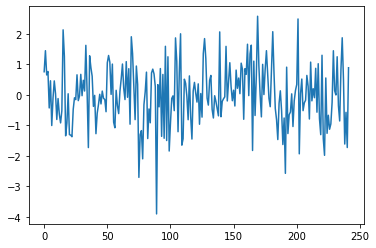

In [252]:
plt.plot(np.mean(mask_data,1))